## Convolutional Neural Networks

In [1]:
import torch
import torch.nn as nn

In [2]:
conv = nn.Conv2d(3, 16, kernel_size=3)

In [3]:
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [4]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

##### Load Image

In [5]:
import matplotlib.pyplot as plt

In [6]:
import imageio
from skimage.transform import resize

In [7]:
cat_img = imageio.imread("data/cat.jpg")

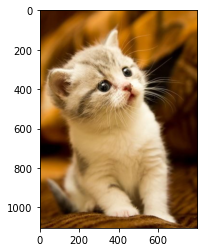

In [8]:
plt.imshow(cat_img)

In [9]:
cat_img.shape

(1105, 800, 3)

In [10]:
# convert to tensor
cat_tensor = torch.from_numpy(cat_img)
cat_tensor = cat_tensor.permute(2, 0, 1)
cat_tensor.shape, cat_tensor.dtype

(torch.Size([3, 1105, 800]), torch.uint8)

In [11]:
# convert dtype to float
cat_tensor = cat_tensor.float()

##### Forward Pass

In [12]:
out = conv(cat_tensor.unsqueeze(0))

In [13]:
out.shape

torch.Size([1, 16, 1103, 798])

In [14]:
out[0, 0].shape

torch.Size([1103, 798])

##### plot output features of the convolution

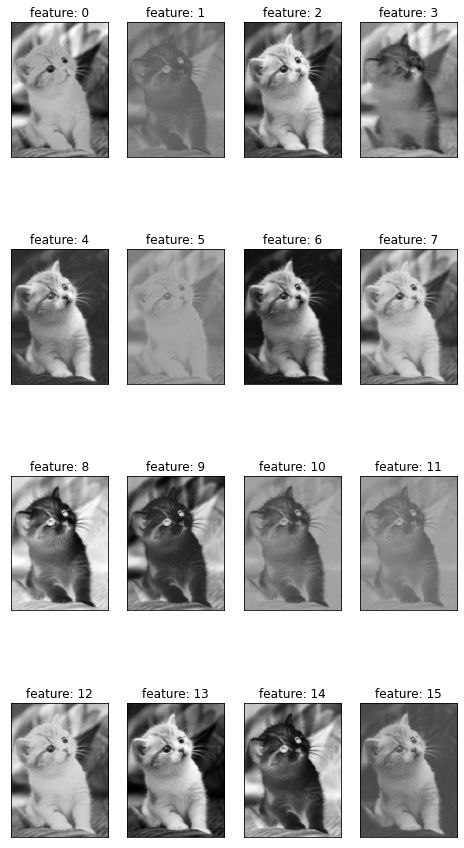

In [15]:

fig, ax = plt.subplots(4, 4, figsize=(8, 16))

index = 0
for i in range(4):
    for j in range(4):
        axes = ax[i][j]
        axes.set_xticks([])
        axes.set_yticks([])
        axes.imshow(out[0, index].detach(), cmap="gray")
        axes.set_title(f"feature: {index}")
        index += 1

##### Using Padding

In [16]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

In [17]:
out = conv(cat_tensor.unsqueeze(0))

In [18]:
cat_tensor.unsqueeze(0).shape, out.shape # same size due to padding

(torch.Size([1, 3, 1105, 800]), torch.Size([1, 1, 1105, 800]))

#### Playing with Kernels and Convolutions

##### Blurring - kernel is constructed such a way that the convolution produces the output pixel to be the average of surrounding pixels

In [19]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

In [20]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0 / 9.0) # there are 9 elements in the kernel, and the convolution averages over them

In [21]:
out = conv(cat_tensor.unsqueeze(0))

In [22]:
out.shape

torch.Size([1, 1, 1105, 800])

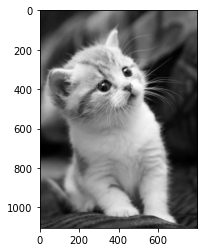

In [23]:
plt.imshow(out[0, 0].detach(), cmap='gray')

##### Vertical Edge Detection Kernel

In [24]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

In [25]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight[:] = torch.tensor([[-1, 0, 1],
                                   [-1, 0, 1],
                                   [-1, 0, 1]], dtype=torch.float32)

In [26]:
out = conv(cat_tensor.unsqueeze(0))

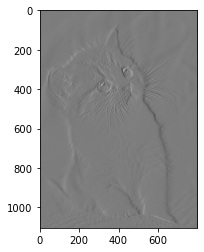

In [27]:
plt.imshow(out[0, 0].detach(), cmap='gray')

In [28]:
edge_conv_out = out

#### Downsampling and Max Pooling

In [29]:
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

In [30]:
out = maxpool(cat_tensor.unsqueeze(0))

In [31]:
cat_tensor.unsqueeze(0).shape, out.shape

(torch.Size([1, 3, 1105, 800]), torch.Size([1, 3, 552, 400]))

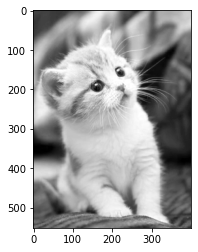

In [32]:
plt.imshow(out[0, 0].detach(), cmap="gray")

##### Coupling with Convolutions

In [33]:
# the previous output we got from the vertical edge detection convolution
edge_conv_out.shape

torch.Size([1, 1, 1105, 800])

In [34]:
out = maxpool(edge_conv_out)

In [35]:
out.shape

torch.Size([1, 1, 552, 400])

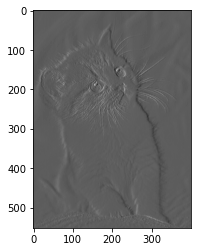

In [36]:
plt.imshow(out[0, 0].detach(), cmap="gray")

Text(0.5, 1.0, 'Max pooled output of edge convolution')

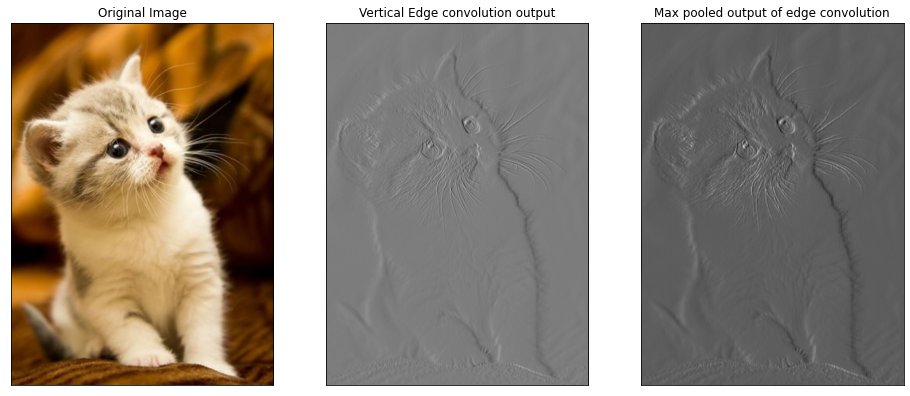

In [37]:
# comparing the original image, edge convolution output, and max pooling output

fig, axes = plt.subplots(1, 3, figsize=(16, 8))

axes[0].imshow(cat_img)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Original Image")

axes[1].imshow(edge_conv_out[0, 0].detach(), cmap="gray")
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("Vertical Edge convolution output")

axes[2].imshow(out[0, 0].detach(), cmap="gray")
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title("Max pooled output of edge convolution")

We can clearly see that max pooling has intensified the features we got from convolution

#### Our Network as nn.Module

In [38]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # flattening
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [39]:
model = ConvNet()

In [40]:
numel_list = [p.numel() for p in model.parameters()]

In [41]:
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

##### Using nn.Functional Counterparts

In [42]:
import torch.nn.functional as F

In [43]:
class ConvNetv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),  kernel_size=2, stride=2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),  kernel_size=2, stride=2)
        out = out.view(-1, 8 * 8 * 8) # this needs to be changed as image size changes
                                      # better way is to use nn.Flatten
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [44]:
model = ConvNetv2()

##### Testing on an Image

In [45]:
cat_img_resized = resize(cat_img, (32, 32))

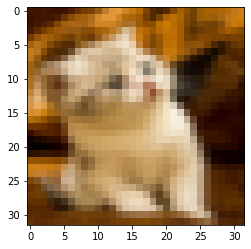

In [46]:
plt.imshow(cat_img_resized)

In [47]:
cat_tensor_resized = torch.from_numpy(cat_img_resized)

In [48]:
cat_tensor_resized = cat_tensor_resized.float()

In [49]:
cat_tensor_resized = cat_tensor_resized.permute(2, 0, 1)

In [50]:
model(cat_tensor_resized.unsqueeze(0))

tensor([[ 0.0080, -0.1091]], grad_fn=<AddmmBackward>)

### Training the model

#### Loading the data

In [51]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [52]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [53]:
dataset_path = "./data"
cifar10 = datasets.CIFAR10(
    dataset_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [54]:
cifar10_val = datasets.CIFAR10(
    dataset_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [55]:
class_names = ['airplane', 'bird']
label_map = {0:0, 2:1}

In [56]:
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [57]:
train_dataloader = DataLoader(cifar2, batch_size=64, shuffle=True)
val_dataloader = DataLoader(cifar2_val, batch_size=64, shuffle=True)

##### Training

In [58]:
from tqdm import tqdm
import torch.optim as optim

In [59]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
n_epochs = 100

In [69]:
train_loss_list = []
val_loss_list = []
for epoch in tqdm(range(1, n_epochs)):
    
    # train
    cummulative_loss = 0
    n_batches = 0
    for imgs, labels in train_dataloader:
        outputs = model(imgs)
        train_loss = loss(outputs, labels)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        cummulative_loss += train_loss
        n_batches += 1
    
    loss_per_epoch = cummulative_loss / n_batches
    train_loss_list.append(loss_per_epoch)
    
    # val
    cummulative_loss_val = 0
    n_batches_val = 0
    for imgs, labels in val_dataloader:        
        with torch.no_grad():
            outputs = model(imgs)
            val_loss = loss(outputs, labels) 
            
        cummulative_loss_val += val_loss
        n_batches_val += 1
        
    loss_per_epoch_val = cummulative_loss_val / n_batches_val
    val_loss_list.append(loss_per_epoch_val)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [05:56<00:00,  3.60s/it]


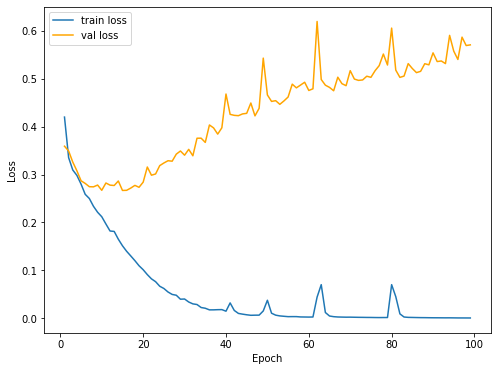

In [70]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.plot(list(range(1, n_epochs)), train_loss_list, label="train loss")
axes.plot(list(range(1, n_epochs)), val_loss_list, color='orange', label="val loss")

axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")

plt.legend()

##### Measuring Accuracy

In [73]:
def get_accuracy(model, train_dataloader, val_dataloader):
    for mode, loader in [("train", train_dataloader), ("val", val_dataloader)]:
        corrects = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, preds = torch.max(outputs, dim=1)
                total += labels.shape[0]
                corrects += int(sum(preds == labels))
        
        print(f"Accuracy {mode}: {round(corrects/total, 4)}")
            

In [74]:
get_accuracy(model, train_dataloader, val_dataloader)

Accuracy train: 1.0
Accuracy val: 0.8955


##### Saving the Model

In [60]:
import os

In [76]:
torch.save(model.state_dict(), os.path.join(dataset_path, "birds_vs_airplanes.pt"))

##### Load the model

In [61]:
model_loaded = ConvNetv2()

In [62]:
model_loaded.load_state_dict(torch.load(os.path.join(dataset_path, "birds_vs_airplanes.pt")))

<All keys matched successfully>

#### Training on GPU

In [62]:
torch.cuda.is_available()

True

In [63]:
device = torch.device('cuda')

In [64]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
n_epochs = 100

In [65]:
model.to(device=device)

ConvNetv2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [67]:
train_loss_list = []
val_loss_list = []
for epoch in tqdm(range(1, n_epochs)):
    
    # train
    cummulative_loss = 0
    n_batches = 0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(imgs)
        train_loss = loss(outputs, labels)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        cummulative_loss += train_loss
        n_batches += 1
    
    loss_per_epoch = cummulative_loss / n_batches
    train_loss_list.append(loss_per_epoch)
    
    # val
    cummulative_loss_val = 0
    n_batches_val = 0
    for imgs, labels in val_dataloader:    
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        with torch.no_grad():
            outputs = model(imgs)
            val_loss = loss(outputs, labels) 
            
        cummulative_loss_val += val_loss
        n_batches_val += 1
        
    loss_per_epoch_val = cummulative_loss_val / n_batches_val
    val_loss_list.append(loss_per_epoch_val)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [01:04<00:00,  1.53it/s]


### CNNs from scratch

Tinkering how a cnn works behind the scenes,